# Introduction

In this notebook I build a neural network from scratch to train and identify images of cats. This neural network is a simple L-layer model that also optionally implements L2 regularization in an attempt to avoid overfitting. Many of the building blocks and ideas for this project are largely influenced by the Deep Learning Specialization courses available on Coursera by DeepLearning.AI.

Here is an outline for how this neural network will work:

- First we initialize the parameters for an $L$-layer neural network
- Next we implement the forward propagation module (shown in purple in the figure below)
- Follwing this, we compute the loss
- We then implement the backward propagation module (denoted in red in the figure below)
- Lastly, we update the parameters

<img src="images/outline.png" style="width:800px;height:500px;">
<caption><center><b>Figure 1</b></center></caption><br>

### Importing packages and data:
Here we will load all our necessary packages and import the train and test data.

In [1]:
## Import all packages
import numpy as np
import h5py
import random
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 15)
np.random.seed(1)

In [2]:
## Import train and test data
train = h5py.File('train.h5','r')
test = h5py.File('test.h5','r')

train_x, train_y = train['train_set_x'], train['train_set_y']
test_x, test_y = test['test_set_x'], test['test_set_y']

train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

Now that the data is loaded let's look at the keys and shapes of each array:

In [3]:
print(train.keys()) # see what keys are in the data
print ("train_x shape: " + str(train_x.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x shape: " + str(test_x.shape))
print ("test_y shape: " + str(test_y.shape))

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>
train_x shape: (209, 64, 64, 3)
train_y shape: (209,)
test_x shape: (50, 64, 64, 3)
test_y shape: (50,)


So we have 209 training images, 50 test images, and 64x64 RGB images. Let's plot 10 random images from the training set:

In [4]:
## Show ten random images from the training set.
def show_random_images(images):
    randomlist = random.sample(range(0, train_x.shape[0]), 10)
    i = 1
    for r in randomlist:
        plt.subplot(2,5,i).set_title('y={}'.format(train_y[r]))
        plt.imshow(images[r])
        i += 1

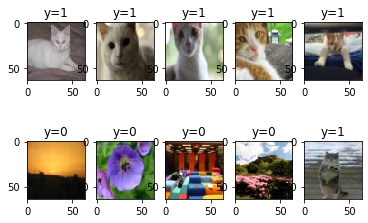

In [5]:
show_random_images(train_x)

We can also see what the target values are for cats ($y=1$) and non-cats ($y=0$). Now let's flatten and normalize the arrays so we can use them as input for the neural network.

In [6]:
## Flatten the training and testing arrays
X = train_x.reshape(train_x.shape[0], -1).T
X_test = test_x.reshape(test_x.shape[0], -1).T
Y = train_y.reshape(1, train_y.shape[0])
Y_test = test_y.reshape(1,test_y.shape[0])

In [7]:
## Normalize the input arrays
X = X / np.max(X)
X_test = X_test / (np.max(X))

Now we can start building the neural network. My approach will be to define many of the functions that build the NN separately and then put them together at the end. Let's start by defining the activation functions we will use in this notebook: the ReLU function and the sigmoid function.

In [8]:
## Define sigmoid and ReLU functions as well as their derivatives for the backwards propagation

def sigmoid(x):
    s =  1. / (1. + np.exp(-x))
    return s

def activation_forward(Z, activation):
    if activation == 'relu':
        A = Z * (Z > 0)
        return A, Z
    if activation == 'sigmoid':
        A = sigmoid(Z)
        return A, Z
    
def activation_backward(dA, Z, activation):
    if activation == 'relu':
        dZ = dA * (Z > 0)
        return dZ
    if activation == 'sigmoid':
        dZ = dA * sigmoid(Z) * (1. - sigmoid(Z))
        return dZ

Now it's time to define a function that can take a list of units per layer and initialize the parameters. For this notebook I will implement a He initialization (based on [He et al. 2015](https://arxiv.org/pdf/1502.01852.pdf)) where you multiply the initialized parameters from numpy.random.randn() by $\sqrt{\frac{2}{\rm{dimension\ of\ previous\ layer}}}$

In [9]:
## Definintion that will initialize hyperparameters for model
def initialize_parameters(layer_dims):
    parameters = {}
    L = layer_dims
    np.random.seed(3)
    for i in range(1, len(L)):
        parameters['W' + str(i)] = np.random.randn(L[i], L[i-1]) * np.sqrt(2. / L[i-1])
        parameters['b' + str(i)] = np.zeros((L[i], 1))
    return parameters

# Forward Propagation

I will now define several functions that implement the forward propagation steps for the neural network. The figure below shows what the forward propagation is doing at each step. At each layer the network takes inputs from the previous layer and applies an activation function. Here, we apply the ReLU function to all hidden layers and the sigmoid function to the output layer.

<img src="images/model_architecture_kiank.png" style="width:600px;height:300px;">
<br>


Time to define the first step in the forward propagation. The inputs will take either the input data $X$ or the activation $A$ from the previous layer to compute $Z = W \cdot A + b$ 

In [10]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

Following this we pass $Z$ through the activation function $g(\cdot)$ to get $A$:

In [11]:
def linear_activation_forward(A_prev, W, b, activation):
    """"
    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    Z, linear_cache = linear_forward(A_prev, W, b)
    A, activation_cache = activation_forward(Z, activation)
    cache = (linear_cache, activation_cache)
    
    return A, cache
        

Let's put it all together in the following function to perform the forward propagation.

In [12]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                 every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2 # number of layers in the neural network
    
    for l in range(1,L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(l+1)], parameters['b' + str(l+1)], 'sigmoid')
    caches.append(cache) 
    

    return AL, caches

After the forward propagation we compute the cost function $J$ using the following formula (where $L$ denotes the current layer and $i$ denotes the $i$th training example): $$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{1}$$

In this function I will also add an optional parameter that will apply L2 regularization if set to True. In that case, the cost will be computed with the following formula:

$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

In [13]:
def compute_cost(AL, Y, parameters,regularized = False,lambd=0.1):
    """
    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]
    cost = -np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL)) / m
    cost = np.squeeze(cost)
    
    L = len(parameters) // 2
    
    list_of_sums = []
    
    for i in range(1, L):
        W = parameters['W' + str(i)]
        list_of_sums.append(np.sum(np.square(W)))
    if not regularized:
        return cost
    if regularized:
        L2_cost = cost + lambd / (2 * m) * np.sum(list_of_sums)
        return L2_cost
    
    return L2_cost

## Define prediction function that takes parameters and returns accuracy + array of predictions 
def predict(X, Y, parameters):
    AL, caches = L_model_forward(X, parameters)
    Y_prediction = np.where(AL[0,:] > 0.5, 1, 0).reshape((1,AL.shape[1]))
    true = 0
    false = 0
    for i in range(Y.shape[1]):
        if Y_prediction[0,i] == Y[0,i]:
            true += 1
        else:
            false += 1
    accuracy = true / (true + false)
    return accuracy, Y_prediction
    

# Backwards Propagation

We now begin defining the backwards propagation functions. The figure below shows a brief overview of the network architecture:

<img src="images/backprop_kiank.png" style="width:650px;height:250px;">

The chain rule of calculus can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $Z^{[1]}$ in a 2-layer network as follows:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{3} $$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, we use the previous chain rule and do $dW^{[1]} = dZ^{[1]} \times \frac{\partial Z^{[1]} }{\partial W^{[1]}}$. During backpropagation, at each step we multiply the current gradient by the gradient corresponding to the specific layer to get the gradient we want.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, we use the previous chain rule and do $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

Now, similarly to forward propagation, we're going to build the backward propagation in three steps:
1. LINEAR backward
2. LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
3. [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)

In [14]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / m 
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)
    
    
    return dA_prev, dW, db

In [15]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    Z = activation_cache
    dZ = activation_backward(dA, Z, activation)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

When defining the function that puts together all of the backwards propagation steps I will also add an optional parameter that implements L2 regularization to the backwards propagation. In that case, I simply add the L2 regularization term to $dW$: ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$).

In [16]:
def L_model_backward(AL, Y, caches, regularized = True, lambd=0.1):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    (linear_cache, Z) = current_cache
    A_prev, W, b = linear_cache
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, 'sigmoid')
    grads['dA' + str(L-1)] = dA_prev_temp
    grads['db' + str(L)] = db_temp
    if not regularized:
        grads['dW' + str(L)] = dW_temp 
    if regularized:
        grads['dW' + str(L)] = dW_temp + lambd/m * W
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        (linear_cache, Z) = current_cache
        A_prev, W, b = linear_cache
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, 'relu')
        grads['dA' + str(l)] = dA_prev_temp
        grads['db' + str(l+1)] = db_temp 
        if not regularized:
            grads['dW' + str(l+1)] = dW_temp
        if regularized:
            grads['dW' + str(l+1)] = dW_temp + lambd/m * W
        
    return grads
    

Now we define a function to update the parameters based on the output from the backwards propagation:

In [17]:
def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    params -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    parameters = params.copy()
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

It's finally time to put it all together! The following function puts together all the steps for the forward and backward propagation

In [18]:
def L_layer_model(X, Y, layer_dims, learning_rate, num_iterations, print_cost=False, plot_cost=False, regularized=False, lambd=0.1):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    costs = []                         # keep track of cost
    parameters = initialize_parameters(layer_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y, parameters, lambd, regularized)
        grads = L_model_backward(AL, Y, caches, lambd, regularized)
        parameters = update_parameters(parameters, grads, learning_rate)
        # Print or plot the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if plot_cost and i % 10 == 0 or i == num_iterations - 1:
            plt.plot(i, cost, marker='o',color='black')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            plt.xlim(0, num_iterations)
            plt.xlabel(r'num iterations')
            plt.ylabel(r'$J$')
            plt.ylim(0,0.9)
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

Now that are model is ready to run, let's define the hyperparamters of the neural network below to use as input:

In [19]:
layer_dims = [X.shape[0], 20, 7, 5, 1] # 4 layer NN. The numbers give after the 1st entry give # of units in each layer
learning_rate = 0.0075
num_iterations =  2500
regularized = False


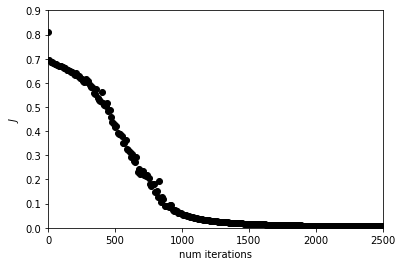

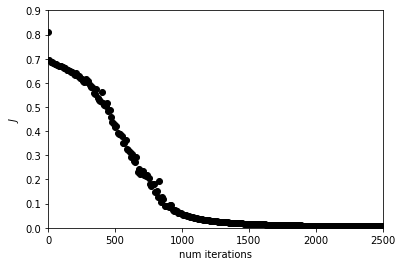

In [20]:
parameters, costs = L_layer_model(X, Y,layer_dims, learning_rate, num_iterations, plot_cost = True)

In [21]:
accuracy, Y_predict_train = predict(X, Y, parameters)
print('Train accuracy:', accuracy)

Train accuracy: 1.0


In [22]:
accuracy, Y_predict_test = predict(X_test, Y_test, parameters)
print('Test accuracy:', accuracy)

Test accuracy: 0.84


/Users/jonathanflorez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


So we get almost $100\%$ accuracy on the training set and $84 \%$ accuracy on the test set! Not bad for a network built from scratch. Now let's try regularizing and see what happens.

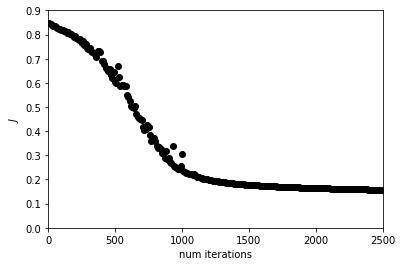

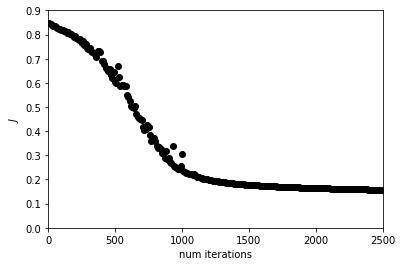

In [23]:
parameters, costs = L_layer_model(X, Y,layer_dims, learning_rate, num_iterations, plot_cost = True, regularized=True, lambd=0.7)

In [24]:
accuracy, Y_predict_train = predict(X, Y, parameters)
print('Train accuracy:', accuracy)

Train accuracy: 1.0


In [25]:
accuracy, Y_predict_test = predict(X_test, Y_test, parameters)
print('Test accuracy:', accuracy)

Test accuracy: 0.88


/Users/jonathanflorez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


A moderate improvement! While the training data is still likely being overfit due to the accuracy being nearly $100 \%$, the cost has lowered and the test accuracy has gone from $84 \%$ to $88 \%$.

Lastly, let's take a look at the labeled images and the predictions:

In [26]:
def show_test_images(images):
    randomlist = random.sample(range(0, test_x.shape[0]), 20)
    i = 1
    for r in randomlist:
        plt.subplot(4,5,i).set_title('y={}'.format(Y_predict_test[0,r]))
        plt.imshow(images[r])
        i += 1

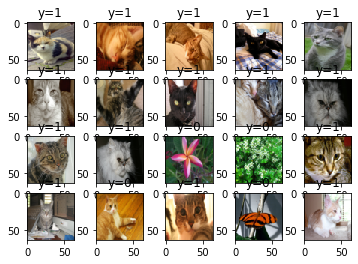

In [27]:
show_test_images(test_x)